Experiment with OpenCV for finding the pool table edges within an image.

This version assumes a full-sized vertical image of the table. It is looking
for the marker pattern along the side of the table.

In [428]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

In [429]:
def ImgShow(images, resolution=120):
    plt.rcParams['figure.dpi'] = resolution
    
    cnt = len(images)
    if cnt > 20:
        # Top-level object is an image, make it an array of 1
        images = [images]
        cnt = len(images)
        
    cols = cnt
    fig, ax = plt.subplots(1, cnt)
    if 1 == cnt:
        ax = [ax]
    for i in range(0, len(images)):
        dims = len(images[i].shape)
        if 3 == dims:
            imgDisp = cv.cvtColor(images[i], cv.COLOR_BGR2RGB)
        else:
            imgDisp = cv.cvtColor(images[i], cv.COLOR_GRAY2RGB)
            
        ax[i].axis('off')
        ax[i].imshow(imgDisp)
        


def ColorRange(clr, fuzz):    
    colorMin = (max(0,clr[0]-fuzz), max(0,clr[1]-fuzz), max(0,clr[2]-fuzz))    
    colorMax = (min(255,clr[0]+fuzz), min(255,clr[1]+fuzz), min(255,clr[2]+fuzz))
    return colorMin, colorMax
        
#Handy color switcher
clrs = []
clrs.append((255,0,0))
clrs.append((0,255,0))
clrs.append((0,0,255))
clrs.append((255,255,0))
clrs.append((255,0,255))
clrs.append((0,255,255))
iClr = 0

def Color():
    global iClr
    iClr += 1
    return clrs[iClr % len(clrs)]
    
clr = Color()

In [430]:
# Handy circle class
class Circle:
    def __init__(self, x,y,r):
        self.x = int(x)
        self.y = int(y)
        self.r = int(r)
        
    def center(self):
        return (self.x, self.y)
    
    def radius(self):
        return self.r

# Handy line class
class LineP:
    def __init__(self, circleA, circleB):
        x1 = circleA.center()[0]
        y1 = circleA.center()[1]
        x2 = circleB.center()[0]
        y2 = circleB.center()[1]
        #print("{0} - {1}".format(y2,y1))
        rise = float(y2 - y1)
        run  = float(x2 - x1)
        if run != 0.0:
            self.m = rise/run
        else:
            self.m = float(10E10)
        self.b = float(y1 - self.m * x1)
        self.radius = float(circleA.radius() + circleB.radius()) / 2.0
        self.circles = []
        self.circles.append(circleA)
        self.circles.append(circleB)
    
    def addCircle(self, circle):
        # scan for duplicates
        for c in self.circles:
            if c.radius() == circle.radius() and c.center()[0] == circle.center()[0] and c.center()[1] == circle.center()[1]:
                return
        self.circles.append(circle)
        
    def val(self):
        return self.m, self.b
        
    def angleRad(self):
        return np.arctan(self.m)
    
    def angleDeg(self):
        return self.angleRad() * 180.0 / math.pi
    
    def pointCount(self):
        return len(self.circles)
    
    def circleRadius(self):
        return self.radius
        
    def distance(self, point):
        a = self.m
        b = -1.0
        c = self.b        
        x = point[0]
        y = point[1]
        d = abs(a*x + b*y + c) / math.sqrt(a*a + b*b)
        return float(d)
    
    def endpoints(self):
        # Scan for the farthest points
        d2Max = 0
        for i in range(0, len(self.circles)-1):
            for j in range(i+1, len(self.circles)):
                dx = self.circles[i].center()[0] - self.circles[j].center()[0]
                dy = self.circles[i].center()[1] - self.circles[j].center()[1]
                d2 = dx*dx + dy*dy
                if d2 > d2Max:
                    d2Max = d2
                    p1 = self.circles[i].center()
                    p2 = self.circles[j].center()
        return p1,p2
    
    def length(self):
        # distance between endpoints
        p1,p2 = self.endpoints()
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        return math.sqrt(dx*dx + dy*dy)
    
    
# Test the endpoints
c1 = Circle(0.0,0.0,1.0)
c2 = Circle(10.0,0.0,1.0)
c3 = Circle(20.0,0.0,1.0)
line = LineP(c1, c2)
pt1, pt2 = line.endpoints()
line.addCircle(c1)
line.addCircle(c3)
line.addCircle(c2)
pt1, pt2 = line.endpoints()
print(pt1, pt2)
m,b = line.val()
print(m,b)

(0, 0) (20, 0)
0.0 0.0


In [431]:
# Talk to the amcrest camera
from amcrest import AmcrestCamera
import os

if False:
    camera = AmcrestCamera('192.168.0.209', 80, 'honeybadger', 'DoucheBag').camera
    #print(camera.software_information)
    filename = "__amcrest_camera_.jpg"
    camera.snapshot(path_file=filename)
    imageCam = cv.imread(filename)
    os.remove(filename)
    ImgShow(imageCam)


In [432]:
# Load the test image
imageOriginal = cv.imread("../test/images/long_all.jpg")

imageFeltFlood shape         = (4032, 3024, 3)
imageFeltFloodMaskBrdr shape = (4034, 3026, 1)
imageFeltFloodMask shape    = (4032, 3024, 1)


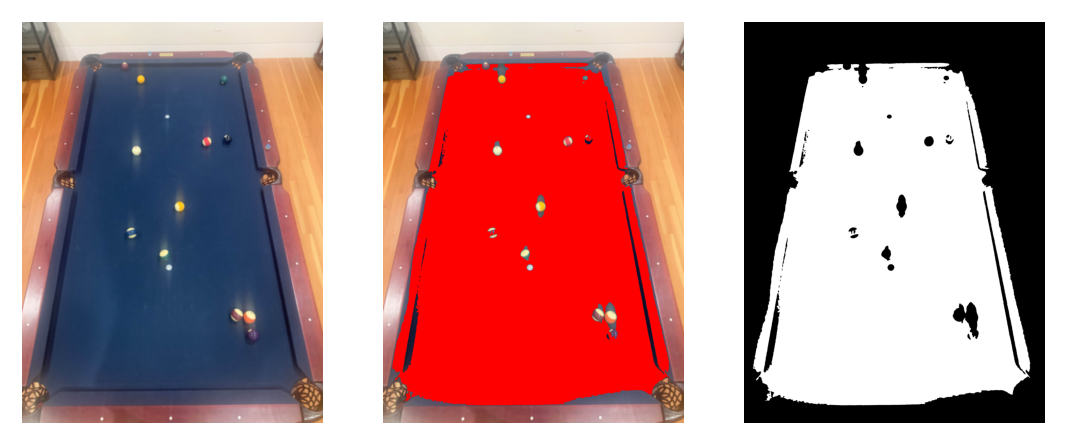

In [433]:
#Find the edges using flood, start with a blur
blur = int(45)
imageBlur = cv.GaussianBlur(imageOriginal, (blur,blur), cv.BORDER_DEFAULT)

imageFeltFlood = imageBlur.copy()
cols = imageFeltFlood.shape[1]
rows = imageFeltFlood.shape[0]
seed = (int(cols / 2), int(rows / 2)) # a point in the middle

imageFeltFloodMaskBrdr = np.zeros((rows+2,cols+2,1), np.uint8)
tolerance = 42.0
diff = (tolerance,tolerance,tolerance)
flags = 8 | cv.FLOODFILL_FIXED_RANGE | 255 << 8
res = cv.floodFill(imageFeltFlood, imageFeltFloodMaskBrdr, seed, (0,0,255),diff,diff, flags)

imageFeltFloodMask = imageFeltFloodMaskBrdr[1:rows+1, 1:cols+1]
print("imageFeltFlood shape         = {0}".format(imageFeltFlood.shape))
print("imageFeltFloodMaskBrdr shape = {0}".format(imageFeltFloodMaskBrdr.shape))
print("imageFeltFloodMask shape    = {0}".format(imageFeltFloodMask.shape))
ImgShow([imageBlur, imageFeltFlood, imageFeltFloodMask], 220)

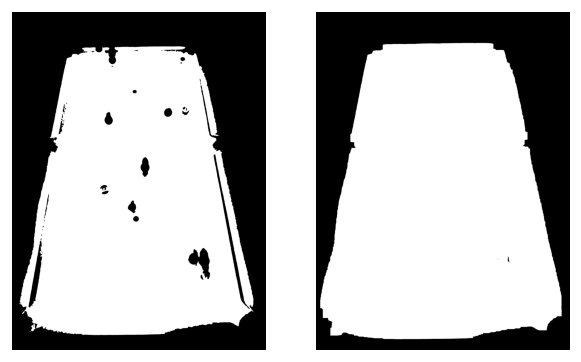

In [460]:
# Brendan's Method
#   Scale the felt up, subtract out the original felt

# Dilate the image 
kernel = np.ones((12,12), np.uint8)
imageFeltFloodMaskDilated = cv.dilate(imageFeltFloodMask, kernel, iterations=8)

# Scale up around the center
factor = 1.25
sizeNew = (imageFeltFloodMaskDilated.shape[0] * factor, imageFeltFloodMaskDilated.shape[1] * factor)
imageExpanded = cv.resize(imageFeltFloodMaskDilated, sizeNew)

ImgShow([imageFeltFloodMask, imageFeltFloodMaskDilated])


In [434]:
# Test indexing with a test pattern
# This shows that indexing is array[row,col]
imageTest = cv.imread("../test/images/TinyGrid 3x2.png")
imageTest = cv.cvtColor(imageTest, cv.COLOR_BGR2GRAY)
print(imageTest[0,0], imageTest[0,1], imageTest[0,2])
print(imageTest[1,0], imageTest[1,1], imageTest[1,2])


0 255 0
255 0 255


Wood Rails


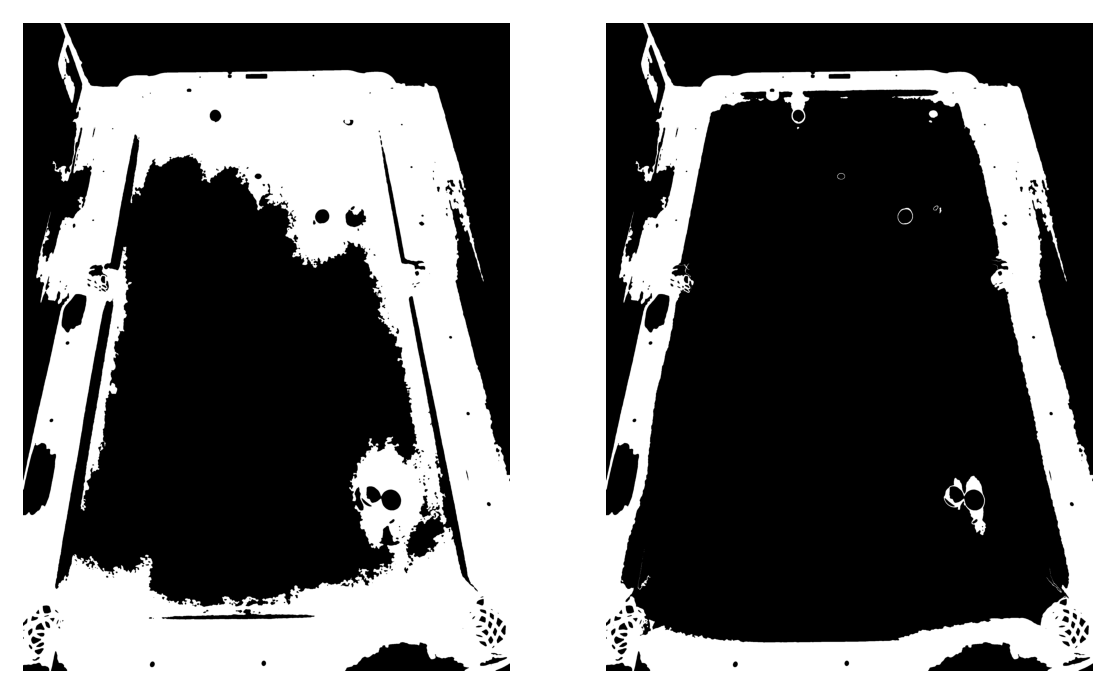

In [453]:
# Extend flood to table sides

def FindLeftRight(img, y):
    cols = img.shape[1]        
    for x in range(cols-1, 7, -1):
        c = img[y, x]
        if(c > 0):
            rightX = x
            break
    for x in range(7, cols):
        c = img[y, x]
        if(c > 0):
            leftX = x
            break
        
    return leftX, rightX
        

def FindTopBottom(img, x):
    rows = img.shape[0]        
    for y in range(rows-1, 7, -1):
        c = img[y, x]
        if(c > 0):
            bottomY = y
            break
    for y in range(7, rows):
        c = img[y, x]
        if(c > 0):
            topY = y
            break
        
    return topY, bottomY
        
# Find all the seeds we will use (2 per side)
# We wil find the rail positions by scanning the mask
seeds = []

y = int(rows * 1.0 / 3.0)
leftX, rightX = FindLeftRight(imageFeltFloodMask, y)
seeds.append((leftX-40, y))
seeds.append((rightX+40, y))

y = int(rows * 2.0 / 3.0)
leftX, rightX = FindLeftRight(imageFeltFloodMask, y)
seeds.append((leftX-40, y))
seeds.append((rightX+40, y))

x = int(cols * 1.0 / 3.0)
topY, bottomY = FindTopBottom(imageFeltFloodMask, x)
seeds.append((x, topY-40))
seeds.append((x, bottomY+40))

x = int(cols * 2.0 / 3.0)
topY, bottomY = FindTopBottom(imageFeltFloodMask, x)
seeds.append((x, topY-40))
seeds.append((x, bottomY+40))

tolerance = 52.0
diff = (tolerance,tolerance,tolerance)
flags = 8 | cv.FLOODFILL_FIXED_RANGE | 255 << 8

# We will merge all masks
imageRailsMaskBrdr = np.zeros((imageBlur.shape[0]+2, imageBlur.shape[1]+2), np.uint8)

clr = (0,255,0)
for seed in seeds:
    imageRails = imageBlur.copy()    
    imageMaskBrdr = np.zeros((imageRails.shape[0]+2,imageRails.shape[1]+2), np.uint8)
    
    res = cv.floodFill(imageRails, imageMaskBrdr, seed, (0,0,255),diff,diff, flags)
    
    cv.circle(imageRails, seed, 40, clr, 10)
    
    #print("Seed={0}".format(seed))
    #ImgShow([imageRails, imageMaskBrdr], 120)
    
    imageRailsMaskBrdr = cv.addWeighted(imageRailsMaskBrdr, 1.0, imageMaskBrdr, 1.0, 0.0)
    
# Remove the mask border
imageRailsMask = imageRailsMaskBrdr[1:rows+1, 1:cols+1]

# Mask out the felt
imageFeltFloodMaskInv = cv.bitwise_not(imageFeltFloodMask)
imageWoodRails = cv.bitwise_and(imageRailsMask, imageFeltFloodMaskInv)
    
print("Wood Rails")
ImgShow([imageRailsMask, imageWoodRails], 230)

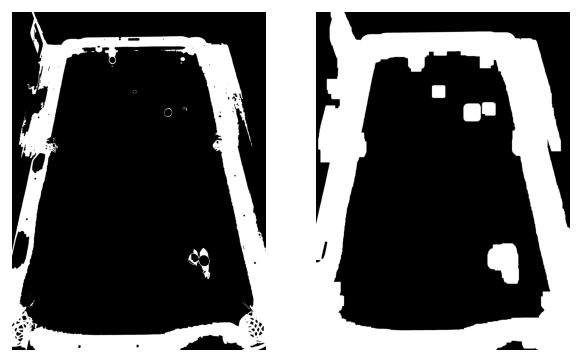

In [457]:
# Dilate (expand) the image just for safety
kernel = np.ones((15,15), np.uint8)

imageWoodRailsExpanded = cv.dilate(imageWoodRails, kernel, iterations=8)
ImgShow([imageWoodRails, imageWoodRailsExpanded])

circles count = 177


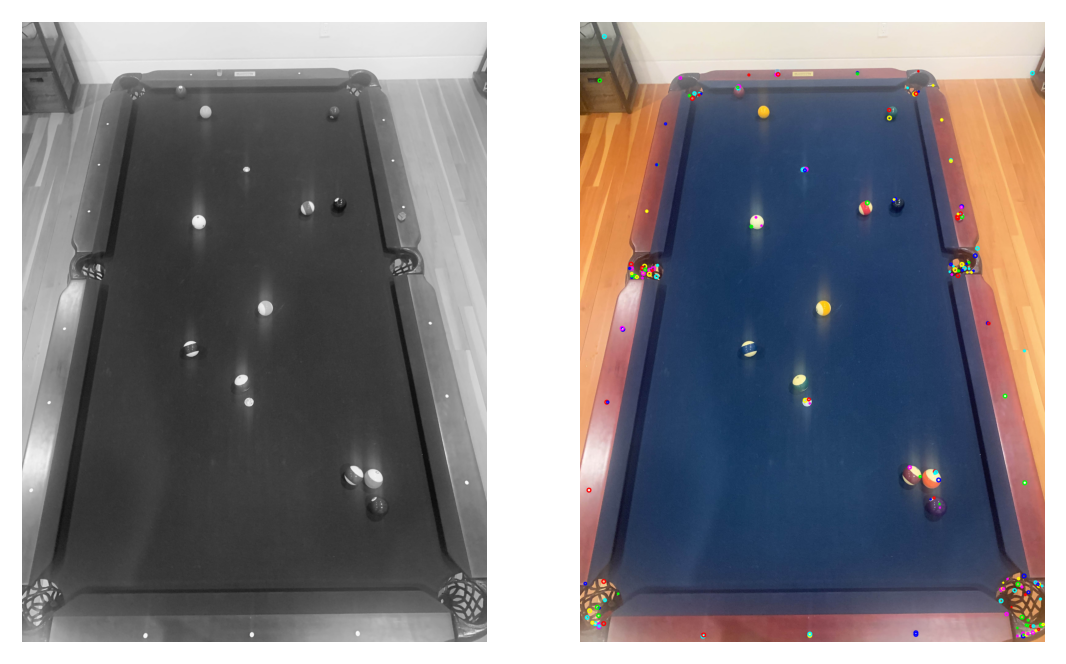

In [436]:
# Hough Circles. 
# Limit by size range and distance
cols = imageOriginal.shape[1]
rows = imageOriginal.shape[0]
imageGray = cv.cvtColor(imageOriginal, cv.COLOR_BGR2GRAY)
imageGray = cv.medianBlur(imageGray, 5)
hcircles = cv.HoughCircles(imageGray, cv.HOUGH_GRADIENT, minDist=5, dp=1,
                               param1=100, param2=10,
                               minRadius=3, maxRadius=13)

# Create an array of our custom Circle objects to hold
circles = []
imageCircles = imageOriginal.copy()
if hcircles is not None:
    hcircles = np.uint16(np.around(hcircles))
    for i in hcircles[0, :]:        
        c = Circle(i[0], i[1], i[2])
    
        # Filter out points ouside of image
        pt = c.center()
        if pt[0] < 0 or pt[1] < 0:
            continue
        if pt[0] > cols-1 or pt[1] > rows-1:
            continue
    
        circles.append(c)
        cv.circle(imageCircles, pt, c.radius(), Color(), 7)
        
print("circles count = {0}".format(len(circles)))
    
ImgShow([imageGray, imageCircles], 220)

color range = (204, 204, 204) - (256, 256, 256)
Prunage: 177 - 39


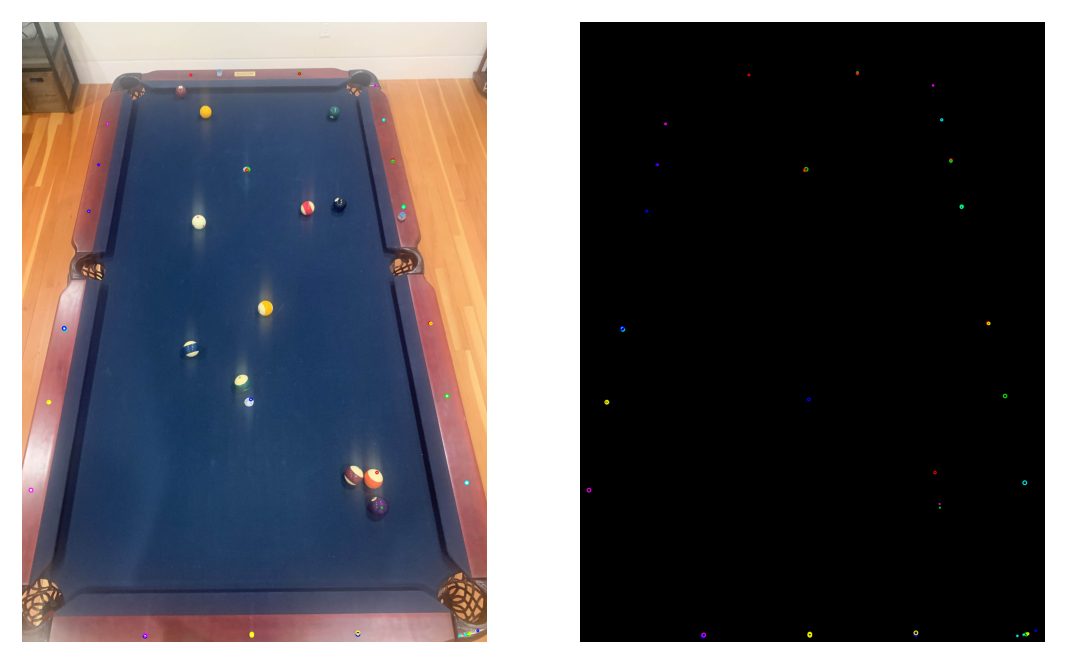

In [437]:
# Filter out circles that don't match the color we want
# We will assume that the circle centers should be whiteish

# Find the range
clrWhite = (240, 240, 240)
fuzz = 35

imageCirclesWhite = imageOriginal.copy()
imageCirclesWhiteBlack = np.zeros(imageOriginal.shape[:3],np.uint8)

clrMin, clrMax = ColorRange(clrWhite, fuzz)
clrMin = (clrMin[0]-1,clrMin[1]-1,clrMin[2]-1,)
clrMax = (clrMax[0]+1,clrMax[1]+1,clrMax[2]+1,)
print("color range = {0} - {1}".format(clrMin, clrMax))
circlesWhite = []
for c in circles:
    pt = c.center()
    
    clr = imageOriginal[pt[1],pt[0]]
    if (clr > clrMin).all() and (clr < clrMax).all():
        circlesWhite.append(c)
        clr = Color()
        cv.circle(imageCirclesWhite, pt, c.radius(), clr, 6)
        cv.circle(imageCirclesWhiteBlack, pt, c.radius(), clr, 6)
        #print("pt={0} clr={1}".format(pt, clr))
print("Prunage: {0} - {1}".format(len(circles), len(circlesWhite)))

ImgShow([imageCirclesWhite, imageCirclesWhiteBlack], 220)

All Lines  309


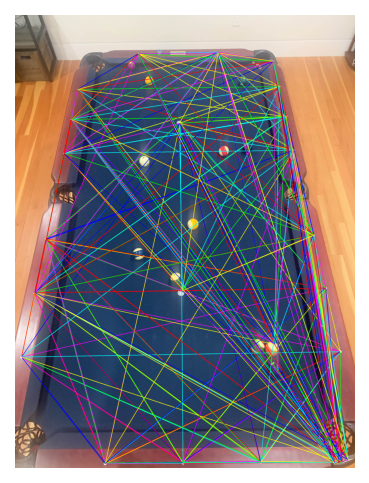

In [438]:
# Between every two points, there is a line. Find all of the possible lines.
linesAll = []
imgLinesAll = imageOriginal.copy()
maxRadiusDiff = 2.0
for i in range(0, len(circlesWhite)-1):
    for j in range(i+1, len(circlesWhite)):
        circleA = circlesWhite[i]
        circleB = circlesWhite[j]
        
        # Don't create lines between circles of different sizes
        radiusDiff = np.abs(circleB.radius() - circleA.radius())
        if(radiusDiff > maxRadiusDiff):
            continue   
        linesAll.append(LineP(circleA, circleB))
        cv.line(imgLinesAll, circleA.center(), circleB.center(), Color(), 3)

# Add each circle to all lines that it lies upon
for circle in circlesWhite:
    # Find the line this might fit on. Give it to all lines that match.
    for line in linesAll:
        if line.distance(circle.center()) > maxRadiusDiff/2.0:
            continue
        radDiff = abs(circle.radius() - line.circleRadius())
        line.addCircle(circle)
        if(radDiff <= maxRadiusDiff):
            line.addCircle(circle)  # Close to the line and withing radius tolerance
            
print("All Lines ", len(linesAll))
ImgShow([imgLinesAll],150)    


Vertical Lines  81


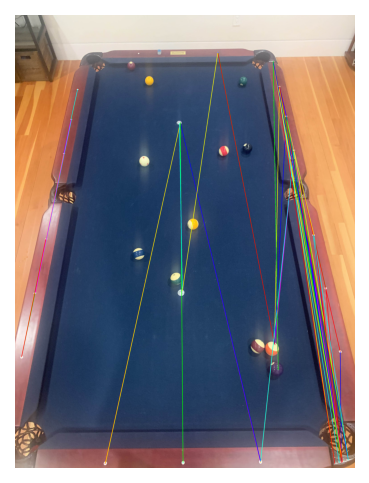

In [439]:
# Extract vertical lines

imgLinesVertical = imageOriginal.copy()
angleLimitV = 14.0 # Only accept lines +/- this angle
linesVertical = []
for line in linesAll:        
    angle = line.angleDeg()
    #print(angle)
    if(angle > 90-angleLimitV and angle < 90+angleLimitV or angle > -90-angleLimitV and angle < -90+angleLimitV):
        linesVertical.append(line)
        p1,p2 = line.endpoints()
        cv.line(imgLinesVertical, p1,p2, Color(), 3)

print("Vertical Lines ", len(linesVertical))

ImgShow([imgLinesVertical],150)    


Pruned Lines len= 9


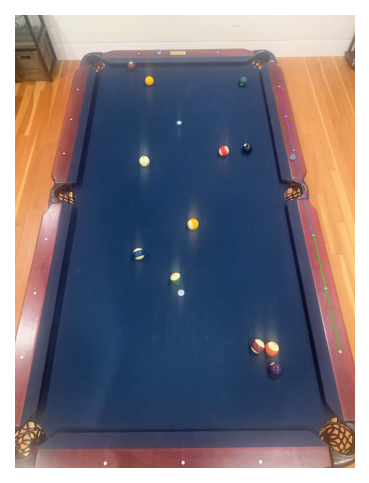

In [440]:
# Extract only the lines that have enough circles that land on it
imgLinesPruned = imageOriginal.copy()
linesPruned= []
# Grab the lines with more than 3 points
for line in linesVertical:
    if line.pointCount() >= 4:
        linesPruned.append(line)
        p1,p2 = line.endpoints()
        cv.line(imgLinesPruned, p1,p2, Color(), 4)
        
print("Pruned Lines len=",len(linesPruned))
        
ImgShow([imgLinesPruned], 150)
for line in linesPruned:
    m,b = line.val()
    #print("line: ", m, b)

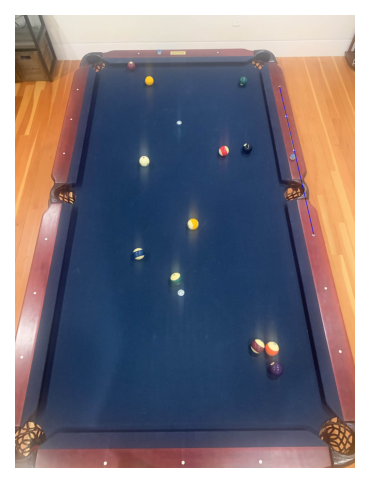

In [441]:
# Find the leftmost and rightmost lines
rows = imageOriginal.shape[0]
cols = imageOriginal.shape[1]
ymid = rows / 2.0
minLeft = cols
maxRight = 0
for line in linesPruned:
    m,b = line.val()
    xmid = (ymid-b)/m
    
    # Left-most?
    if(xmid < minLeft):
        minLeft = xmid
        lineLeft = line
    if(xmid > maxRight):
        maxRight = xmid
        lineRight = line
        
imgLinesSides = imageOriginal.copy()
p1,p2 = lineLeft.endpoints()
cv.line(imgLinesSides, p1,p2, Color(), 4)
p1,p2 = lineRight.endpoints()
cv.line(imgLinesSides, p1,p2, Color(), 4)
ImgShow([imgLinesSides], 150)

Horizontal Lines  32


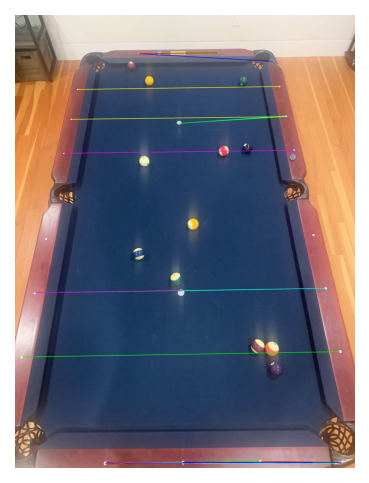

In [442]:
# Extract horizontal lines

imgLinesHorizontal = imageOriginal.copy()
angleLimitH = 5.0 # Only accept lines +/- this angle
linesHorizontal = []
for line in linesAll:        
    angle = line.angleDeg()
    if(angle > -angleLimitH and angle < angleLimitH):
        linesHorizontal.append(line)
        p1,p2 = line.endpoints()
        cv.line(imgLinesHorizontal, p1,p2, Color(), 3)

print("Horizontal Lines ", len(linesHorizontal))

ImgShow([imgLinesHorizontal],150)    


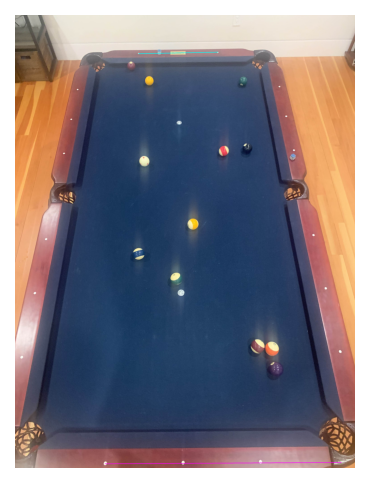

In [443]:
# Find the topmost and bottommost lines
rows = imageOriginal.shape[0]
cols = imageOriginal.shape[1]
xmid = cols / 2.0
minTop = rows
maxBottom = 0
for line in linesHorizontal:
    m,b = line.val()
    ymid = m*xmid + b
    
    # Left-most?
    if(ymid < minTop):
        minTop = ymid
        lineTop = line
    if(ymid > maxBottom):
        maxBottom = ymid
        lineBottom = line
        
imgLinesTopBottom = imageOriginal.copy()

p1,p2 = lineTop.endpoints()
cv.line(imgLinesTopBottom, p1,p2, Color(), 4)
p1,p2 = lineBottom.endpoints()
cv.line(imgLinesTopBottom, p1,p2, Color(), 4)
ImgShow([imgLinesTopBottom], 150)

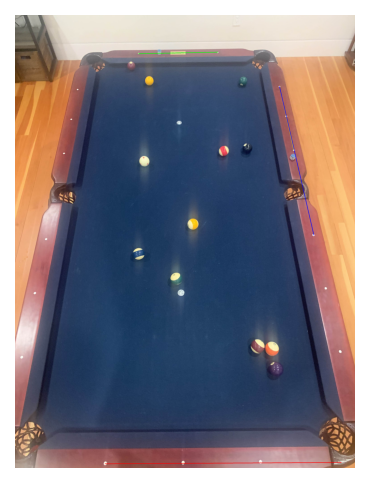

In [444]:
# Show all 4 sides
imgLinesEdges = imageOriginal.copy()

p1,p2 = lineLeft.endpoints()
cv.line(imgLinesEdges, p1,p2, Color(), 4)
p1,p2 = lineRight.endpoints()
cv.line(imgLinesEdges, p1,p2, Color(), 4)

p1,p2 = lineTop.endpoints()
cv.line(imgLinesEdges, p1,p2, Color(), 4)
p1,p2 = lineBottom.endpoints()
cv.line(imgLinesEdges, p1,p2, Color(), 4)

ImgShow([imgLinesEdges], 150)